Num GPUs Available:  1


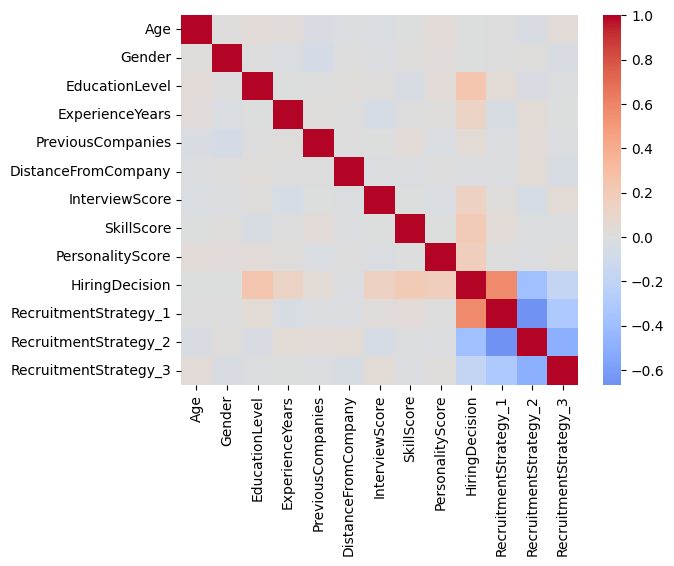

In [2]:
import numpy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import seaborn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import scipy

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

recrutamento = pd.read_csv('recruitment_data.csv', sep=',', decimal='.')

# Instanciando o objeto One-Hot encoder, pois vai ser utilizada na coluna recrutamento Strategy
ohe = OneHotEncoder(handle_unknown='ignore')
# Fazendo a transformação
ohe_df = pd.DataFrame(ohe.fit_transform(recrutamento[['RecruitmentStrategy']]).toarray(), columns=['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3'])

# Agrupando a nova coluna com o df original
df = recrutamento.join(ohe_df)

recrutamento = df.drop(['RecruitmentStrategy'], axis=1)


corrPearson = recrutamento.corr('pearson')

seaborn.heatmap(corrPearson, annot=False, cmap='coolwarm', center=0)

features = list(recrutamento.columns.values)

classificacao = 'HiringDecision'

corrKendall = recrutamento.corr('kendall')

corrPearson = recrutamento.corr('pearson')

corrSpearman = recrutamento.corr('spearman')

tabela_correlacoes = pd.DataFrame()

tabela_correlacoes['kendal']= corrKendall['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['pearson']= corrPearson['HiringDecision'].sort_values(ascending=False)
tabela_correlacoes['spearman']= corrSpearman['HiringDecision'].sort_values(ascending=False)

tabela_correlacoes.drop(tabela_correlacoes[tabela_correlacoes['kendal']==1].index, inplace=True)

tabela_correlacoes

#Verifica-se que a estrategia de recrutamento  =1 que eh a agressiva, vai impactar muito na decisao final de contratacao

#removendo as features que tiveram indice de correlacao menor que 0.1
#tabela_correlacoes[tabela_correlacoes['kendal']<0.1].index

features.remove('PreviousCompanies')
features.remove('Age')
features.remove('Gender')
features.remove('DistanceFromCompany')

#Remove o output
features.remove(classificacao)

X = recrutamento[features].to_numpy() 
Y = recrutamento[classificacao].to_numpy() 



<AxesSubplot:ylabel='Density'>

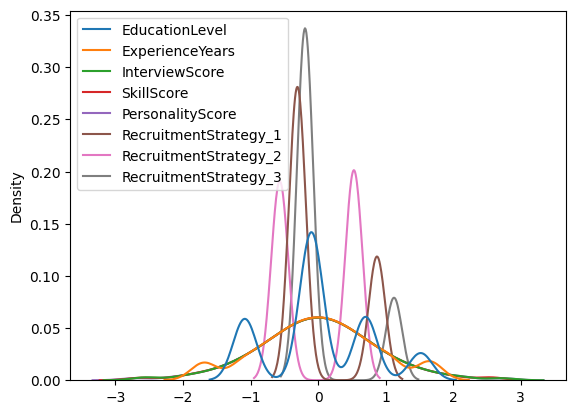

In [3]:
# Normalizando as features X
import scipy


X_scaler1 = StandardScaler()
X_normalizado_standard = X_scaler1.fit_transform(X)


scaler2 = MinMaxScaler()
X_normalizado_min_max = scaler2.fit_transform(X)


X_transformado= X_normalizado_min_max

#Testando usando PCA
# pca = PCA(n_components=3)
# pca.fit(X)

# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

# X_transformado = pca.fit_transform(X= X_transformado)


#seaborn.scatterplot(recrutamento[features]) #melhor pois tem features que tem escala diferente 


#seaborn.boxplot(X_transformado)


#seaborn.kdeplot(X)

#seaborn.kdeplot(X_transformado)

X_new= pd.DataFrame()
for feature in features:
  x_ranked = (scipy.stats.rankdata(recrutamento[feature])/(X.shape[0]+1)-.5)*2
  X_new[feature] = numpy.arctanh(x_ranked)



X_transformado = X_new.to_numpy()
seaborn.kdeplot(X_new)



In [4]:
# PARAMETROS DA REDE 
maximo_neuronios = 5
funcoes_ativacao = ['tanh', 'relu', 'sigmoid'] 
metrica = 'Accuracy' 
#quantidade de loops q vai esperar ate q o erro de teste comece a aumentar 
paciencia = 150
max_epocas =3*paciencia
min_improvement = 0.01
adam_initial_lr = 0.01
adam_lr_decay = 0.99
rollback_on_no_lower_bound_gain = True #se comecar o erro a subir, volta pra onde tava bom

# SEED que controla a aleatoriedade 
random_seed = 22
n_k_folds = 5 #quantas partes o dataset vai ser dividido

tf.random.set_seed(random_seed)
#keras.utils.set_random_seed(random_seed)
# DIVIDE EM K PEDACOS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_transformado, Y)

5

In [5]:
#Testando com KerasClassifier
def create_model(neurons, activation='relu'):
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons, input_shape=(X_transformado.shape[1],), kernel_initializer='uniform', activation=activation))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

tf.random.set_seed(random_seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
neurons = [2,3,5]
batch_size = [50,100,300]
epochs = [200, 300, 400]
param_grid = dict(batch_size = batch_size, epochs=epochs, model__neurons=neurons, model__activation=funcoes_ativacao)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_transformado, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/200


In [10]:
# TREINANDO
metric_lower_bound = 0.0
metric_median = 0.0
resultados = []
for n_neuron in numpy.arange(1, maximo_neuronios+1):
    ix_fold = 1
    #divisao os grupos de treino e teste, ele faz pelos indices
    for train_index, test_index in sk_folds.split(X_transformado, Y):
        # pegar o dado do teste  e treino   a partir dos indices da divisao feita pelo skfolds
        X_train, X_test = X_transformado[train_index], X_transformado[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        for funcao_ativacao in funcoes_ativacao : 
            #configurando o otimizador 
            optimizer = tf.keras.optimizers.Adam( learning_rate=adam_initial_lr, 
                                                    beta_1=adam_lr_decay ) 
            
            # Configurando a rede
            model_name = f"ADAM-N{n_neuron}F{ix_fold}_{classificacao}_{funcao_ativacao}"
            val_metric_name = f'val_{metrica}'
            
            inputs = tf.keras.Input(shape=(X_transformado.shape[1], ))        
            hidden = tf.keras.layers.Dense(n_neuron, activation=funcao_ativacao)(inputs)
            outputs = tf.keras.layers.Dense(1, activation='sigmoid')(hidden) #penas 1 classificacao = 1 saida
            rede = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)

            #Usar o otimizador com erro medio quadratico 
            rede.compile(optimizer=optimizer, loss='mse', metrics=[metrica])
            
            #early stop com foco no erro do grupo de validacao
            es_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, restore_best_weights=True)
            #early stop com foco na acuracia dos testes
            es_metric = tf.keras.callbacks.EarlyStopping(monitor=metrica, mode='max', patience=paciencia, min_delta=min_improvement, restore_best_weights=True)


            #iniciando a rede para tentar encontrar o modelo
            resultado = rede.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                    epochs=max_epocas, verbose=0, callbacks=[es_loss, es_metric], )

        

            # RESULTADOS DA REDE
            model_loss = resultado.history['loss'][-1]
            model_val_loss = resultado.history['val_loss'][-1]
            metric_val = resultado.history[metrica][-1]
            val_metric_val = resultado.history[val_metric_name][-1]
            n_epochs = len(resultado.history['val_loss'])

            resultado_dict = {'model_name': model_name,
                            'optimizer': optimizer,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            metrica: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'net': rede,
                            'history': resultado}
            resultados.append(resultado_dict)

            print(f"{model_name} > epochs: {n_epochs} loss: {model_loss} val_loss: {model_val_loss} {metrica}: {100.0*metric_val}% {val_metric_name}: {100.0*val_metric_val}%")
                

            # SE CHEGAR NO 100% para de aumentar 
            maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

            if maximized_metrics:
                break

            print('')
        ix_fold += 1
        
    # GET LOWER BOUND OF WINNING ALGORITHM
    df_resultados = pd.DataFrame(resultados)


ADAM-N1F1_HiringDecision_tanh > epochs: 271 loss: 0.11263589560985565 val_loss: 0.08247116208076477 Accuracy: 85.5833351612091% val_Accuracy: 89.66666460037231%

ADAM-N1F1_HiringDecision_relu > epochs: 427 loss: 0.10988843441009521 val_loss: 0.08171375840902328 Accuracy: 85.25000214576721% val_Accuracy: 88.33333253860474%

ADAM-N1F1_HiringDecision_sigmoid > epochs: 180 loss: 0.19754506647586823 val_loss: 0.19327576458454132 Accuracy: 68.99999976158142% val_Accuracy: 68.99999976158142%

ADAM-N1F2_HiringDecision_tanh > epochs: 250 loss: 0.11129926145076752 val_loss: 0.08382818102836609 Accuracy: 85.66666841506958% val_Accuracy: 89.66666460037231%

ADAM-N1F2_HiringDecision_relu > epochs: 274 loss: 0.11784002929925919 val_loss: 0.08551092445850372 Accuracy: 85.25000214576721% val_Accuracy: 89.33333158493042%

ADAM-N1F2_HiringDecision_sigmoid > epochs: 305 loss: 0.10932394862174988 val_loss: 0.08941390365362167 Accuracy: 85.66666841506958% val_Accuracy: 87.99999952316284%

ADAM-N1F3_HiringD

In [11]:
resultado_resumido = pd.DataFrame()

lista_dict = []
for qtde_neuronio in numpy.arange(1, maximo_neuronios+1):
    for funcao_ativacao in funcoes_ativacao:
        filtrado = df_resultados[(df_resultados['neurons']==qtde_neuronio) & (df_resultados['model_name'].str.contains(funcao_ativacao))]
        temp_dict ={}
        temp_dict['neuronios'] = qtde_neuronio
        temp_dict['ativacao'] = funcao_ativacao
        temp_dict[f'{metrica}_media'] =  filtrado.loc[:, metrica].mean()
        stringVal = f'val_{metrica}'
        temp_dict[f'{stringVal}_media'] =  filtrado.loc[:, stringVal].mean()
        temp_dict[f'epocas_media'] =  filtrado.loc[:, 'epochs'].mean()
        temp_dict[f'val_loss_media'] =  filtrado.loc[:, 'val_loss'].mean()
        temp_dict[f'loss_media'] =  filtrado.loc[:, 'loss'].mean()
        lista_dict.append(temp_dict)
        

resultado_resumido = pd.DataFrame(lista_dict)
resultado_resumido.sort_values(by=f'{metrica}_media', ascending=False)

,neuronios,ativacao,Accuracy_media,val_Accuracy_media,epocas_media,val_loss_media,loss_media
13,5,relu,0.870667,0.855333,258.2,0.110420,0.101004
12,5,tanh,0.869833,0.854667,223.4,0.113099,0.100568
10,4,relu,0.868167,0.855333,292.8,0.110860,0.101631
9,4,tanh,0.867833,0.854667,252.4,0.110874,0.100508
0,1,tanh,0.866000,0.862000,329.6,0.108755,0.105627
7,3,relu,0.865500,0.859333,275.6,0.112350,0.103960
14,5,sigmoid,0.864667,0.858667,253.8,0.108287,0.103390
3,2,tanh,0.864500,0.857333,297.8,0.111423,0.102959
6,3,tanh,0.864000,0.856000,234.6,0.111210,0.103424
11,4,sigmoid,0.864000,0.855333,280.8,0.110197,0.103892
